# Model Based Machine Learning - Used Cars Price Prediction

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.ticker as ticker
%matplotlib inline

C:\Users\NoyTabul\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tasks:
- Add a dataset section (General description and column values)
- Describe the different data types in the dataset (Categorical, Continuous, etc.) Noy)
- Correlation HeatMap (COMPLETED)
- Mutual Information (MI) analysis (COMPLETED)
- Histogram plot of the prices of cars (NOT YET.
- Different code cells for data transformations (Normalization, encoding categorical variables etc.)
- Make different PGM's - start with a basic linear regression model 
- a.r.d for assigning weights to input features to predict output (price)
- Data- and results analysis and comparison

## Data: Description, Preprocessing, and Analysis

In [2]:
# Loading the data and inspect the first rows
df = pd.read_csv('car_price_prediction.csv')
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
# Inspect the dataset: we start with the shape of the dataset, columns, and types
print("Dataset shape: ", df.shape)
print("Columns and Types:")
print(df.dtypes)

Dataset shape:  (19237, 18)
Columns and Types:
ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object


In [4]:
#check for duplications
df.duplicated().sum()

313

In [5]:
# we will drop duplications and check for missing values
df.drop_duplicates(inplace= True)
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

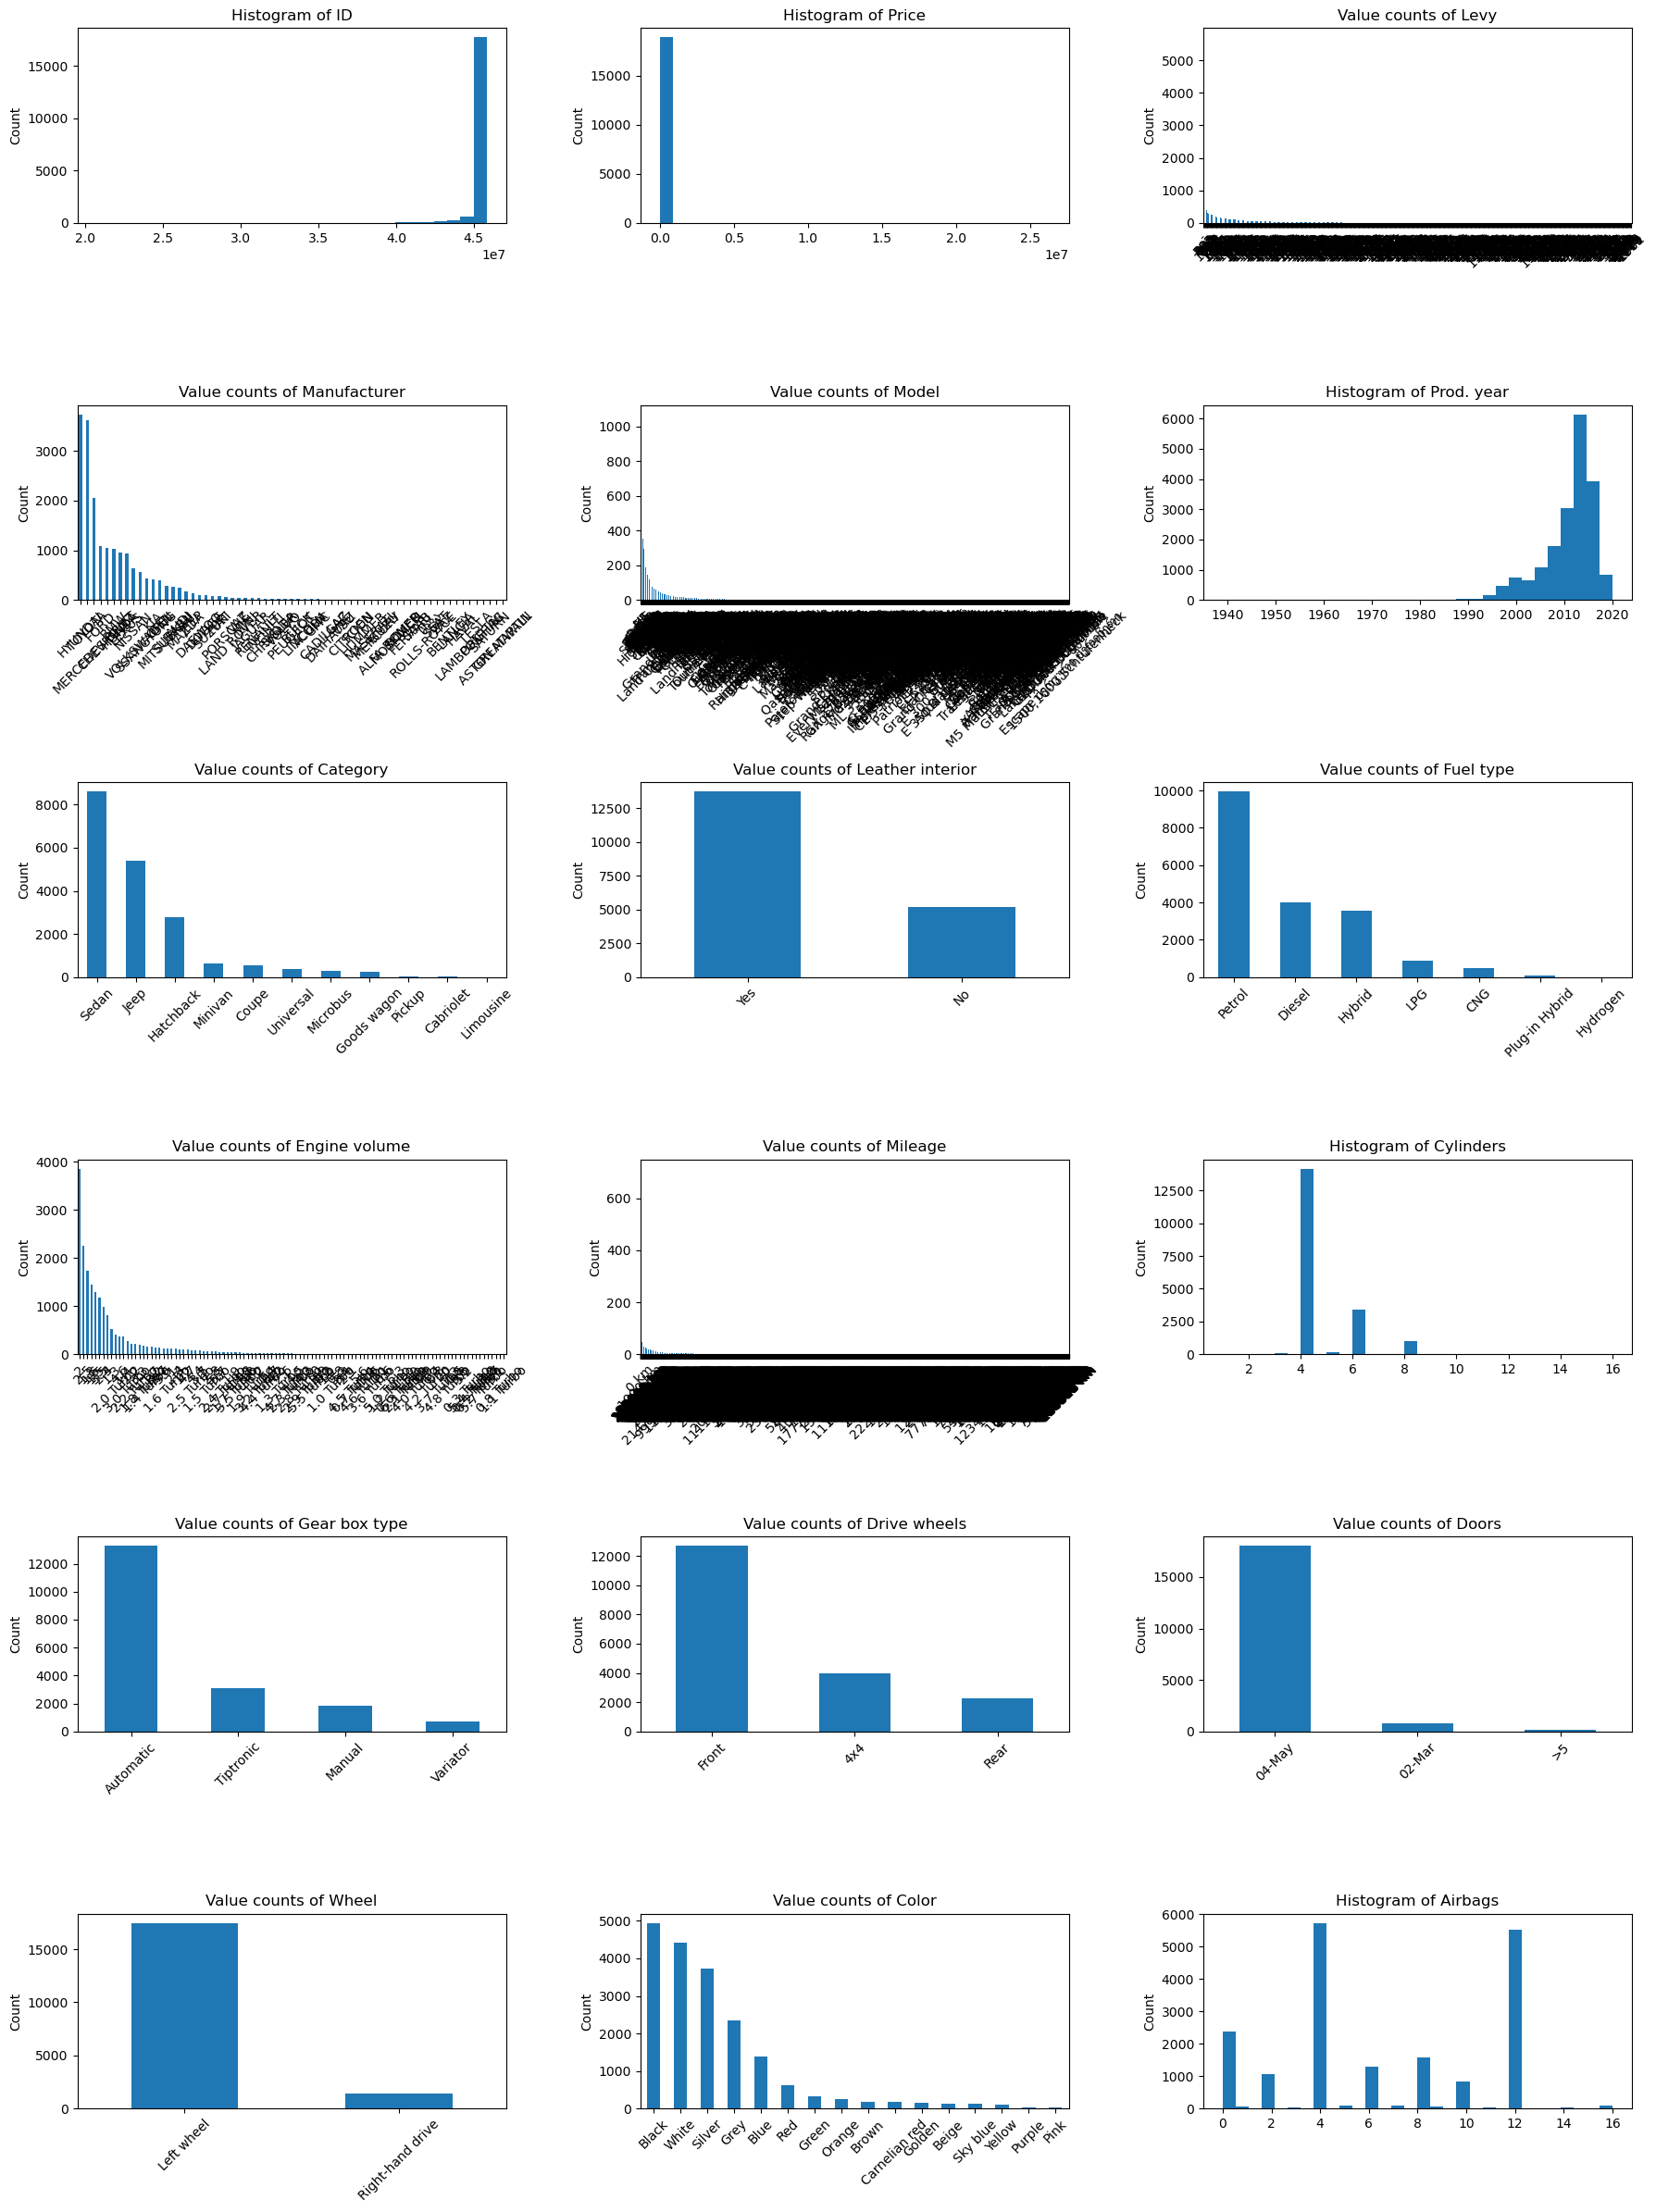

In [6]:
# Number of columns per row in the plot grid
n_cols = 3
n_rows = -(-len(df.columns) // n_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(df.columns):
    ax = axes[i]
    try:
        # If the column can be converted to numeric, use histogram
        df[col].astype(float)
        df[col].astype(float).plot(kind='hist', bins=30, ax=ax)
        ax.set_title(f"Histogram of {col}")
    except:
        # Otherwise, treat as categorical and use bar chart
        df[col].value_counts(dropna=False).plot(kind='bar', ax=ax)
        ax.set_title(f"Value counts of {col}")
        ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

As expected, there are many values that need preprocessing, and we cam also ignore some features that we believe that do not have influence over the price (e.g. Steering wheels side, color). Other features need to be treated differently: for example, milage contains the string "KM", this should be removed and the values should contain only the numerical value. Or, engine volume, that contains som additional information about the engine like "turbo" - which will will split into another binary feature that will contain values 0 or 1 for whether the engine is a turbo engine (0 if not, else 1). Additionally, many of the dataset's attributes are categorical, hence we will use one-hot encoding to fix them and fit them to a regression model.

Another desicion is to drop the attribute "model". This is due to high cardinality. Also, mostly, the model can be captured be other features of the car. i.e. the common sense is saying that the model is a major factor in the price, however, we believe that the rest of the features will capture the quality of a certain model. 

In [7]:
# Check the number of unique values of each column
df.nunique()

ID                  18924
Price                2315
Levy                  559
Manufacturer           65
Model                1590
Prod. year             54
Category               11
Leather interior        2
Fuel type               7
Engine volume         107
Mileage              7687
Cylinders              13
Gear box type           4
Drive wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

In [8]:
# Drop irrelevant columns -4 columns
df_cleaned = df.drop(columns=['ID', 'Model', 'Color', 'Wheel'])

# Levy to numeric
df_cleaned['Levy'] = df_cleaned['Levy'].replace('-', pd.NA)
df_cleaned['Levy'] = pd.to_numeric(df_cleaned['Levy'], errors='coerce')

#Leather interior to binary
df_cleaned['Leather interior'] = df_cleaned['Leather interior'].map({'Yes': 1, 'No': 0})

In [9]:
#check the unique values and additional strings in engine volume
engine_volume_values = df_cleaned['Engine volume'].unique()
sorted(engine_volume_values)

['0',
 '0.1',
 '0.2',
 '0.2 Turbo',
 '0.3',
 '0.3 Turbo',
 '0.4',
 '0.4 Turbo',
 '0.5',
 '0.6',
 '0.6 Turbo',
 '0.7',
 '0.7 Turbo',
 '0.8',
 '0.8 Turbo',
 '0.9',
 '1',
 '1.0 Turbo',
 '1.1',
 '1.1 Turbo',
 '1.2',
 '1.2 Turbo',
 '1.3',
 '1.3 Turbo',
 '1.4',
 '1.4 Turbo',
 '1.5',
 '1.5 Turbo',
 '1.6',
 '1.6 Turbo',
 '1.7',
 '1.7 Turbo',
 '1.8',
 '1.8 Turbo',
 '1.9',
 '1.9 Turbo',
 '2',
 '2.0 Turbo',
 '2.1',
 '2.1 Turbo',
 '2.2',
 '2.2 Turbo',
 '2.3',
 '2.3 Turbo',
 '2.4',
 '2.4 Turbo',
 '2.5',
 '2.5 Turbo',
 '2.6',
 '2.7',
 '2.7 Turbo',
 '2.8',
 '2.8 Turbo',
 '2.9',
 '2.9 Turbo',
 '20',
 '3',
 '3.0 Turbo',
 '3.1',
 '3.2',
 '3.2 Turbo',
 '3.3',
 '3.4',
 '3.5',
 '3.5 Turbo',
 '3.6',
 '3.6 Turbo',
 '3.7',
 '3.7 Turbo',
 '3.8',
 '3.9',
 '4',
 '4.0 Turbo',
 '4.2',
 '4.2 Turbo',
 '4.3',
 '4.4',
 '4.4 Turbo',
 '4.5',
 '4.5 Turbo',
 '4.6',
 '4.6 Turbo',
 '4.7',
 '4.7 Turbo',
 '4.8',
 '4.8 Turbo',
 '5',
 '5.0 Turbo',
 '5.2',
 '5.3',
 '5.4',
 '5.4 Turbo',
 '5.5',
 '5.5 Turbo',
 '5.6',
 '5.7',
 '5.7

In [10]:
# Create 'Turbo' binary column
df_cleaned['Turbo'] = df_cleaned['Engine volume'].str.contains('Turbo').astype(int)

# Extract numeric part of engine volume
df_cleaned['Engine volume'] = df_cleaned['Engine volume'].str.replace(' Turbo', '', regex=False).astype(float)

In [11]:
#Drop 'Fuel type'
df_cleaned = df_cleaned.drop(columns=['Fuel type'])

# Mileage - remove ' km' and convert to numeric
df_cleaned['Mileage'] = df_cleaned['Mileage'].str.replace(' km', '', regex=False).str.replace(',', '')
df_cleaned['Mileage'] = pd.to_numeric(df_cleaned['Mileage'], errors='coerce')

# Cylinders and Airbags - numeric
df_cleaned['Cylinders'] = pd.to_numeric(df_cleaned['Cylinders'], errors='coerce')
df_cleaned['Airbags'] = pd.to_numeric(df_cleaned['Airbags'], errors='coerce')

# Doors to numeric
df_cleaned['Doors'] = df_cleaned['Doors'].str.extract(r'(\d+)')  # extract numeric part
df_cleaned['Doors'] = pd.to_numeric(df_cleaned['Doors'], errors='coerce')

# Preprocessing production year to Age
current_year = datetime.now().year
df_cleaned['Age'] = current_year - df_cleaned['Prod. year']
df_cleaned = df_cleaned.drop(columns=['Prod. year'])

# Preview the cleaned dataframe
df_cleaned.head()

,Price,Levy,Manufacturer,Category,Leather interior,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Airbags,Turbo,Age
0,13328,1399.0,LEXUS,Jeep,1,3.5,186005,6.0,Automatic,4x4,4,12,0,15
1,16621,1018.0,CHEVROLET,Jeep,0,3.0,192000,6.0,Tiptronic,4x4,4,8,0,14
2,8467,NaN,HONDA,Hatchback,0,1.3,200000,4.0,Variator,Front,4,2,0,19
3,3607,862.0,FORD,Jeep,1,2.5,168966,4.0,Automatic,4x4,4,0,0,14
4,11726,446.0,HONDA,Hatchback,1,1.3,91901,4.0,Automatic,Front,4,4,0,11


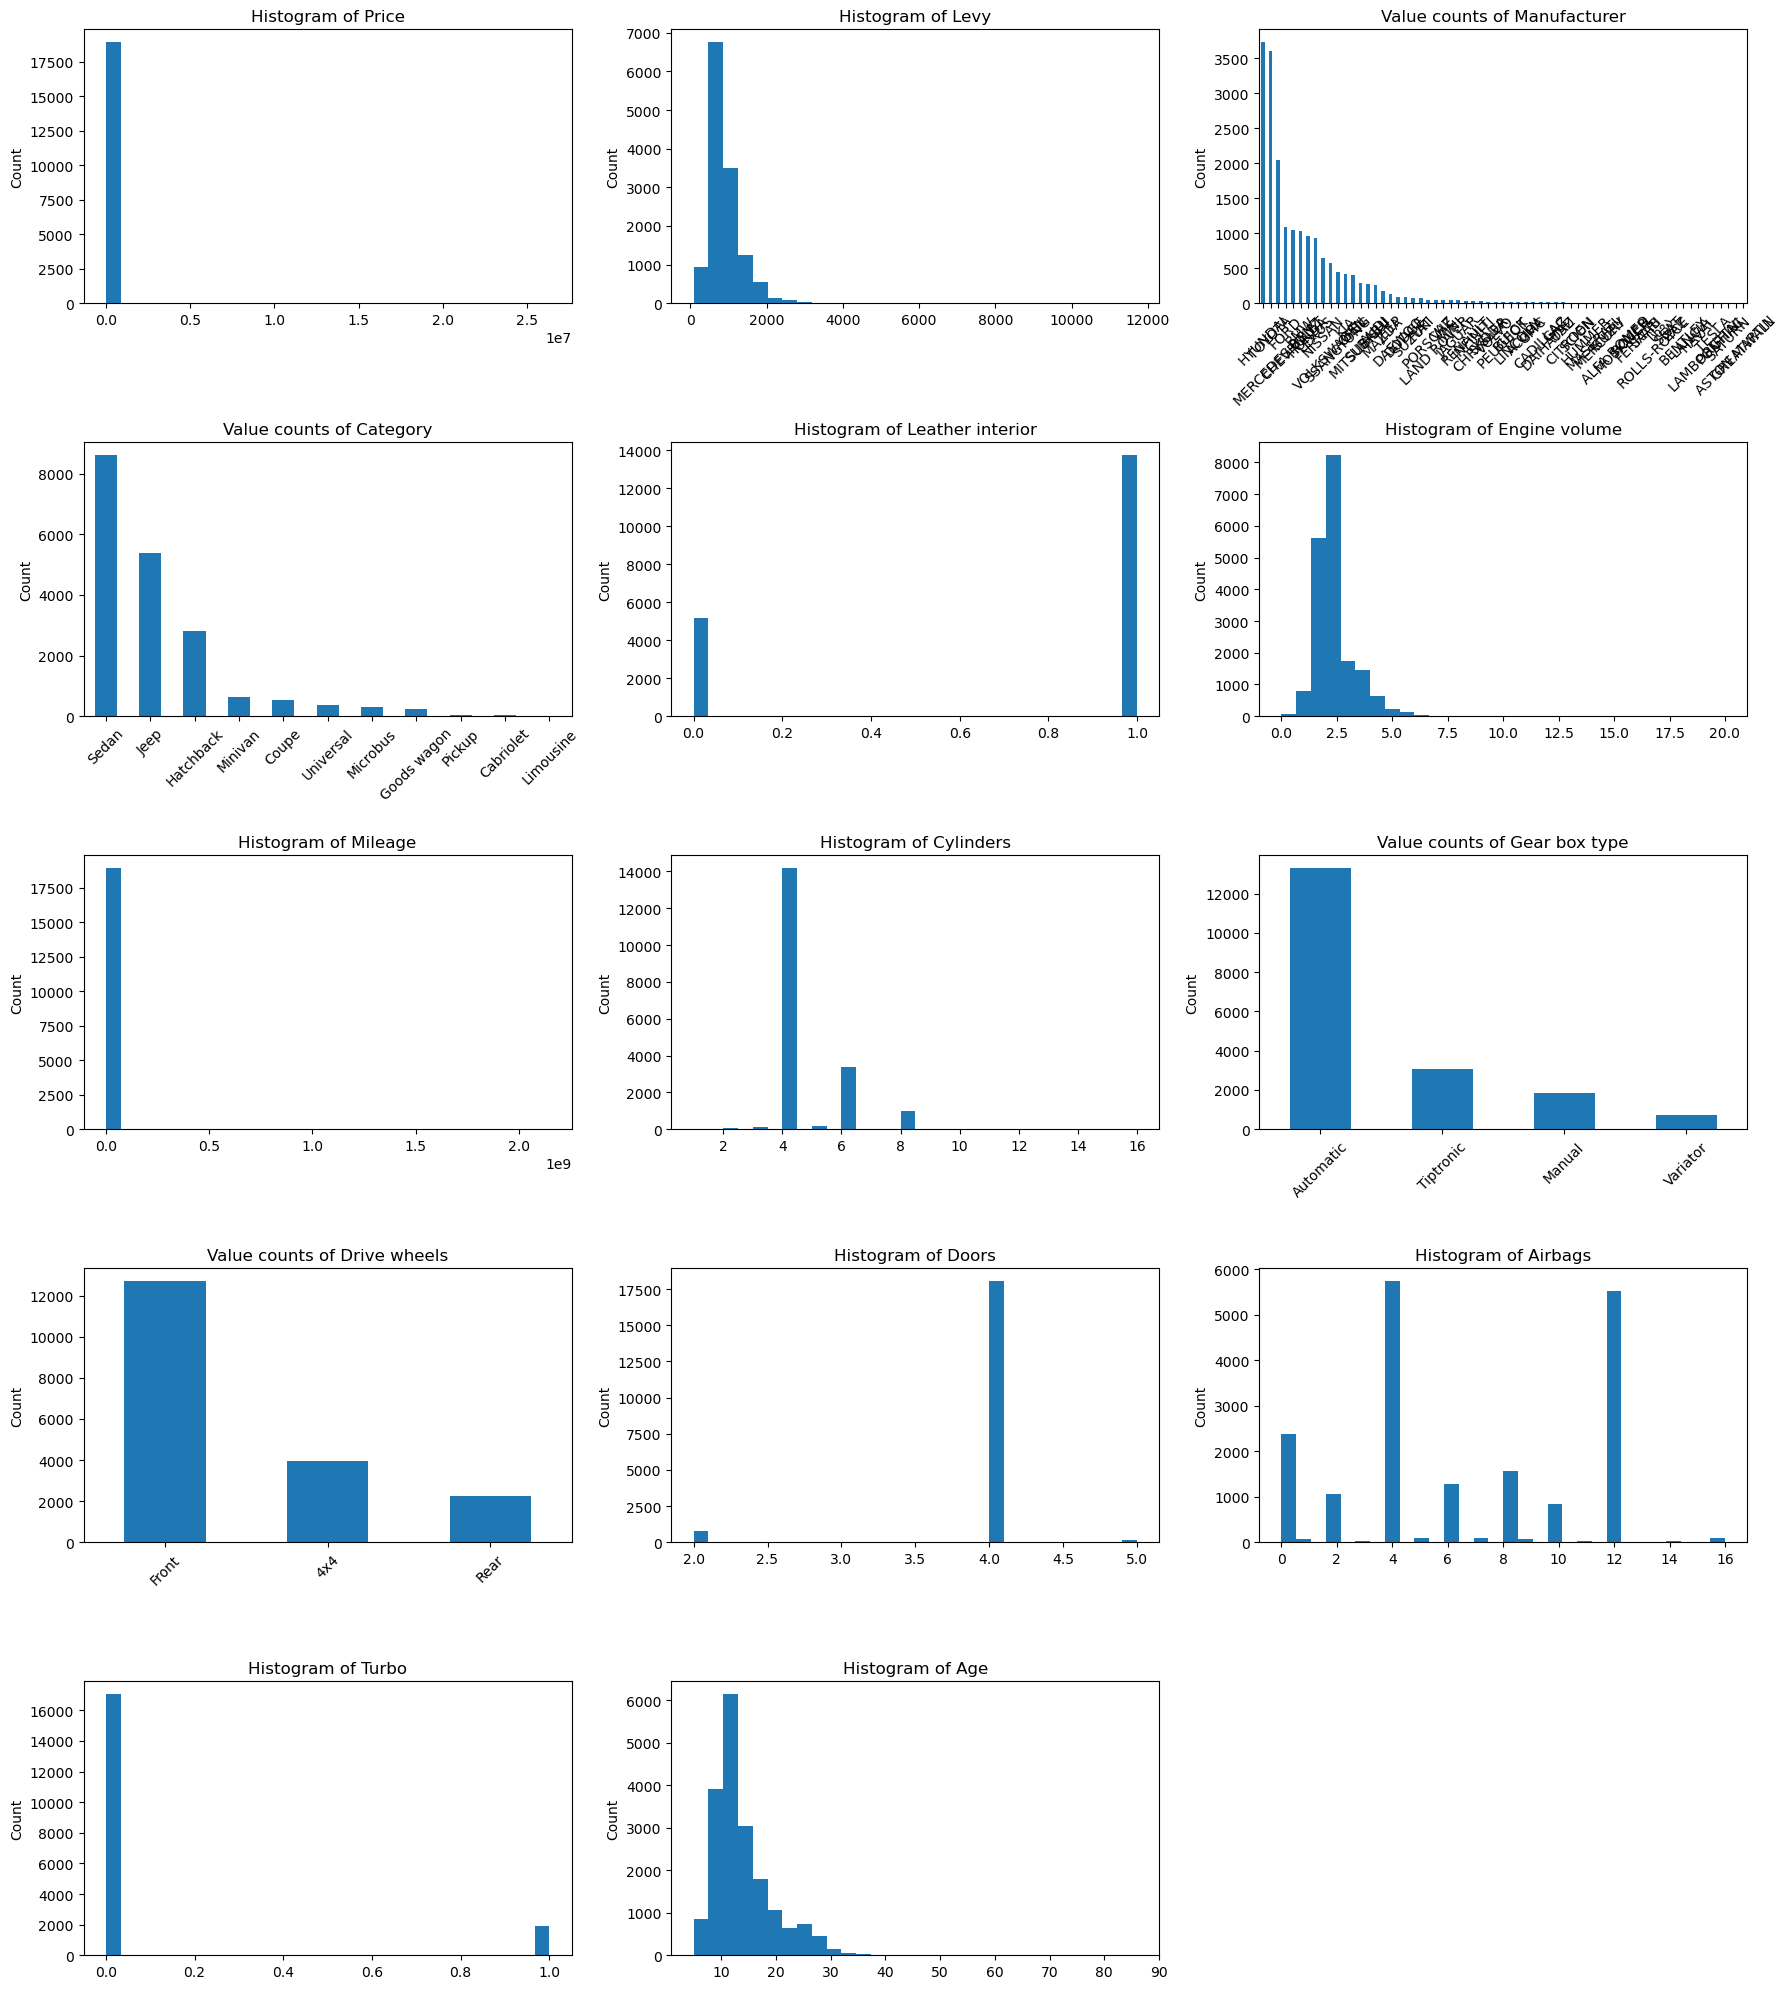

In [12]:
# Number of columns per row in the plot grid
n_cols = 3
n_rows = -(-len(df_cleaned.columns) // n_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(df_cleaned.columns):
    ax = axes[i]
    try:
        # If the column can be converted to numeric, use histogram
        df_cleaned[col].astype(float)
        df_cleaned[col].astype(float).plot(kind='hist', bins=30, ax=ax)
        ax.set_title(f"Histogram of {col}")
    except:
        # Otherwise, treat as categorical and use bar chart
        df_cleaned[col].value_counts(dropna=False).plot(kind='bar', ax=ax)
        ax.set_title(f"Value counts of {col}")
        ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [13]:
print("Descriptive Statistics:")
df_cleaned.describe().T

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Price,18924.0,1.858744e+04,1.921356e+05,1.0,5331.00,13172.0,22063.00,2.630750e+07
Levy,13215.0,9.062992e+02,4.632969e+02,87.0,640.00,781.0,1058.00,1.171400e+04
Leather interior,18924.0,7.255866e-01,4.462300e-01,0.0,0.00,1.0,1.00,1.000000e+00
Engine volume,18924.0,2.306251e+00,8.775910e-01,0.0,1.80,2.0,2.50,2.000000e+01
Mileage,18924.0,1.555373e+06,4.880221e+07,0.0,70195.75,126400.0,189119.75,2.147484e+09
Cylinders,18924.0,4.580216e+00,1.200223e+00,1.0,4.00,4.0,4.00,1.600000e+01
Doors,18924.0,3.925386e+00,4.041379e-01,2.0,4.00,4.0,4.00,5.000000e+00
Airbags,18924.0,6.568379e+00,4.322323e+00,0.0,4.00,6.0,12.00,1.600000e+01
Turbo,18924.0,9.997886e-02,2.999797e-01,0.0,0.00,0.0,0.00,1.000000e+00
Age,18924.0,1.408576e+01,5.665749e+00,5.0,10.00,13.0,16.00,8.600000e+01


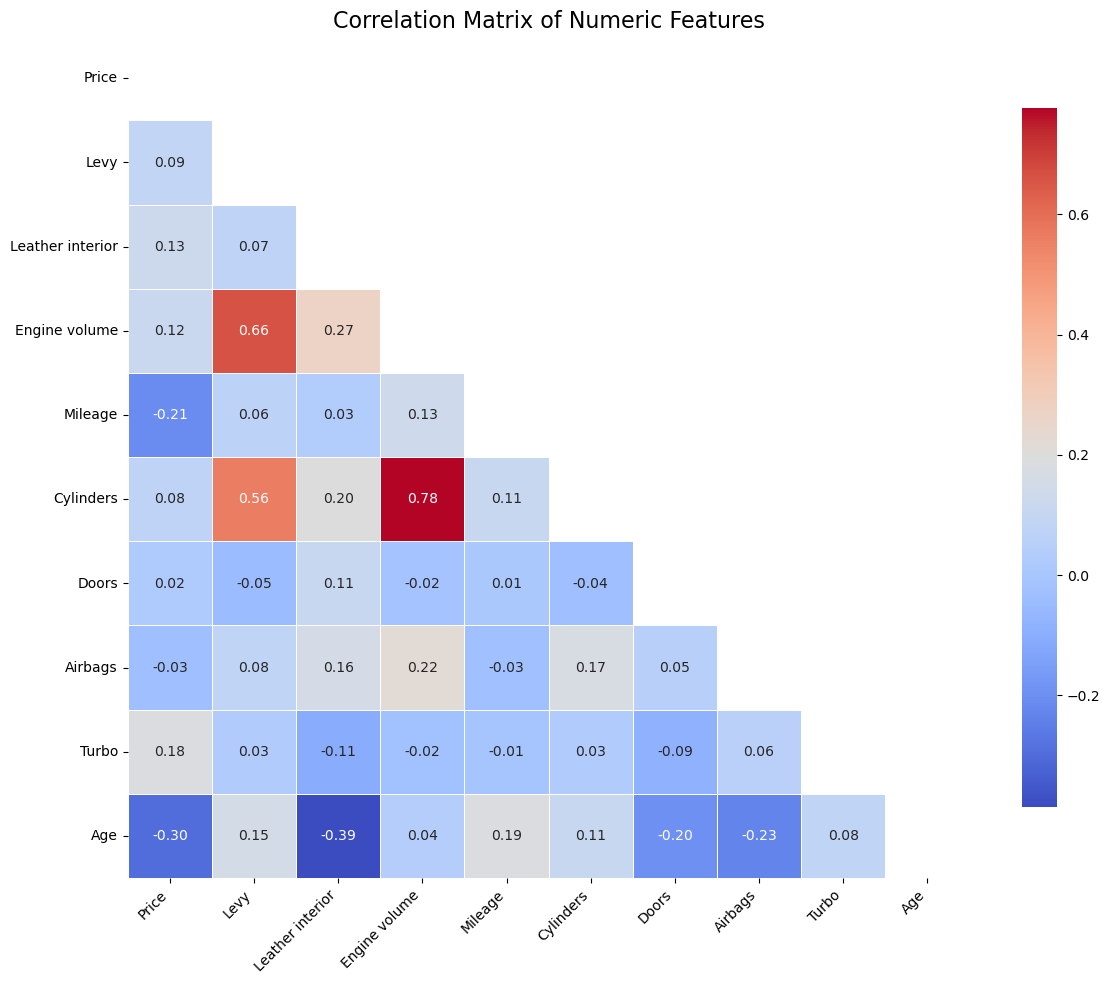

In [110]:
# Select only numeric columns for correlation analysis
numeric_data = df_cleaned.select_dtypes(include=[np.number])

corr = numeric_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(12, 10))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True,
    annot_kws={"size": 10},)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.tight_layout()
fig.savefig('correlation_heat_plot.png', bbox_inches='tight')
plt.show()

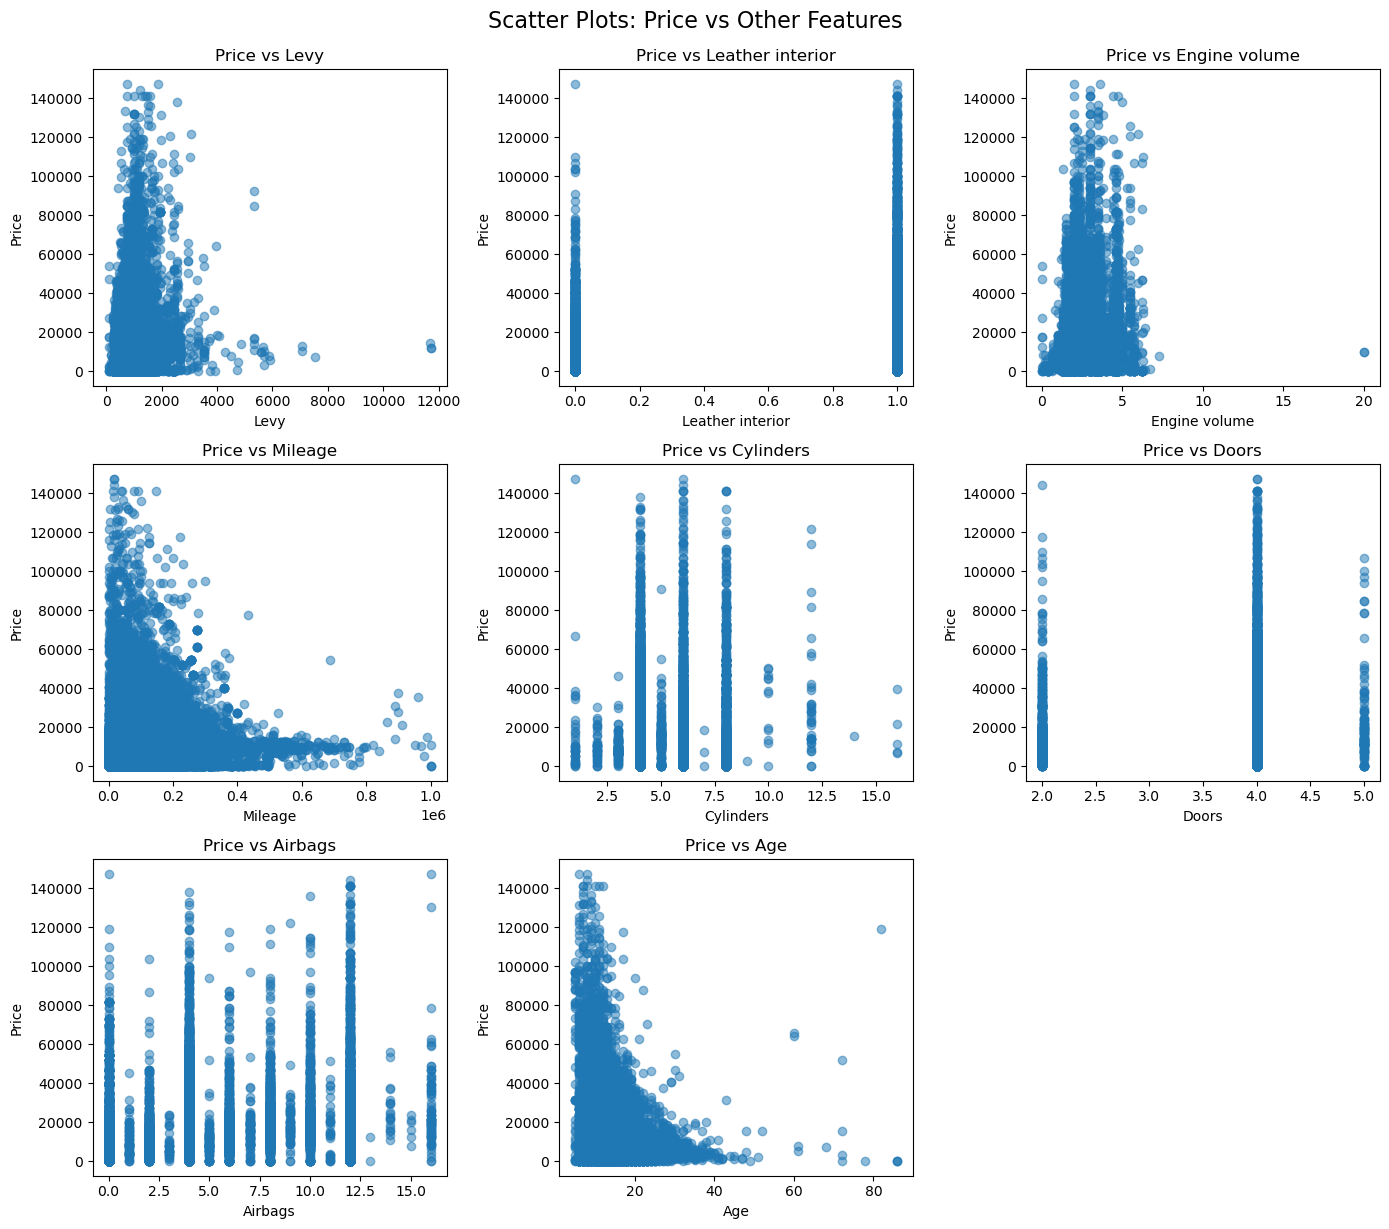

In [104]:
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
features_to_plot = [col for col in numeric_cols if col != 'Price']

n_cols = 3
n_rows = -(-len(features_to_plot) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    ax = axes[i]
    ax.scatter(df_cleaned[col], df_cleaned['Price'], alpha=0.5)
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    ax.set_title(f'Price vs {col}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Scatter Plots: Price vs Other Features', fontsize=16, y=1.02)
fig.savefig('correlation_plots.png', bbox_inches='tight')
plt.show()


#### Key insights:

* Mileage and Age are strong inverse indicators of price and likely valuable features in the model.

* Levy and Engine Volume show weaker, non-linear patterns but might still contribute when combined with other features or in interaction terms.

* To handle skewness, we can use log-price, and check the results accordingly

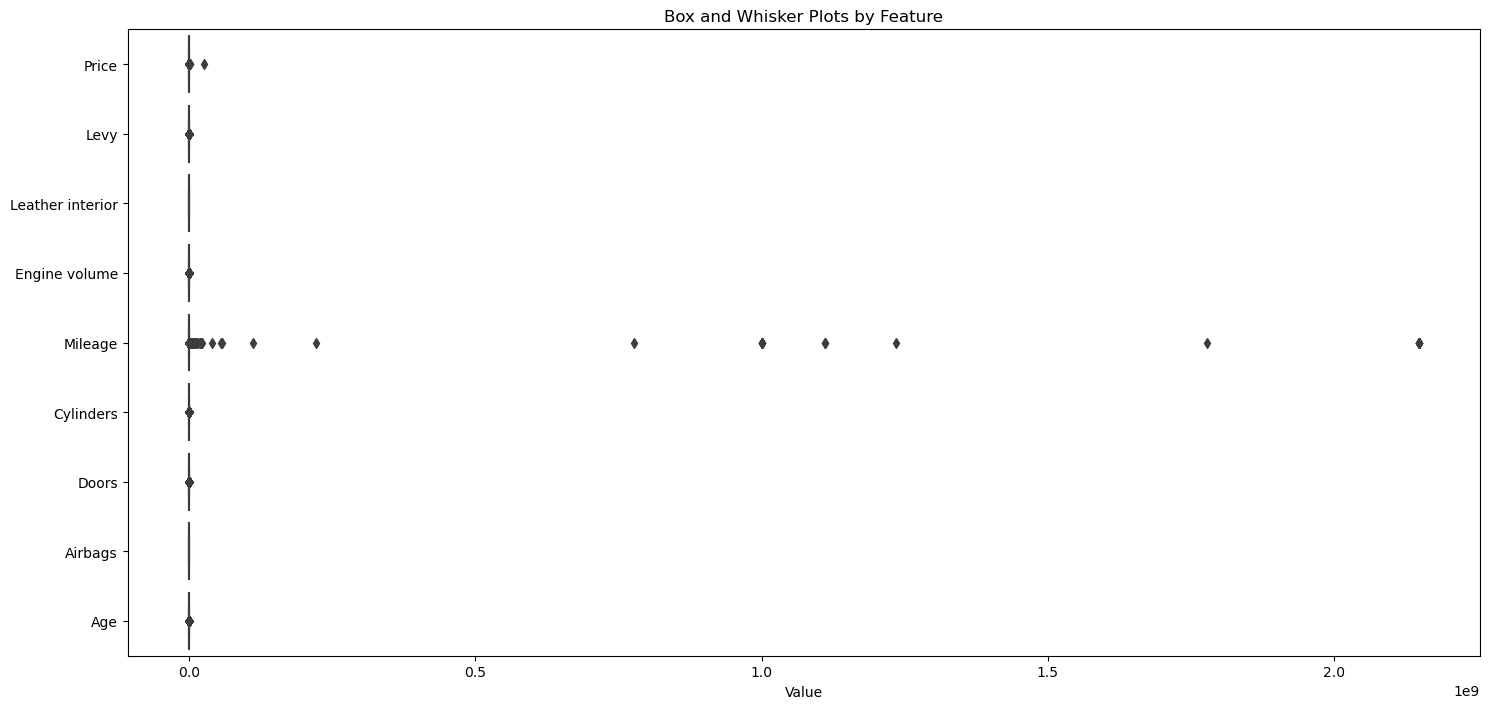

In [14]:
# Select numerical columns only (excluding 'Price' if you want to plot it separately)
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Set up the plot
plt.figure(figsize=(15, len(numerical_cols) * 0.8))
sns.boxplot(data=df_cleaned[numerical_cols], orient='h')
plt.title("Box and Whisker Plots by Feature")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

It looks like the data for the price and mileage got some outliers the influence the distribution. We will inspect the prices further:

In [15]:
print(df_cleaned['Price'].describe())

print(" ")

Q1 = df_cleaned['Price'].quantile(0.25)
Q3 = df_cleaned['Price'].quantile(0.75)
IQR = Q3 - Q1
print("upper bound: ", Q3 + 1.5 * IQR)

count    1.892400e+04
mean     1.858744e+04
std      1.921356e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.206300e+04
max      2.630750e+07
Name: Price, dtype: float64
 
upper bound:  47161.0


In [16]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Price'] > 150000])}")

Number of entries: 27


There are 27 records of cars that their price is greater than 150,000. Since they influence the data that much, we will drop them, and plot the price distribution again:

In [17]:
df_cleaned = df_cleaned[df_cleaned['Price'] <= 150000].copy()

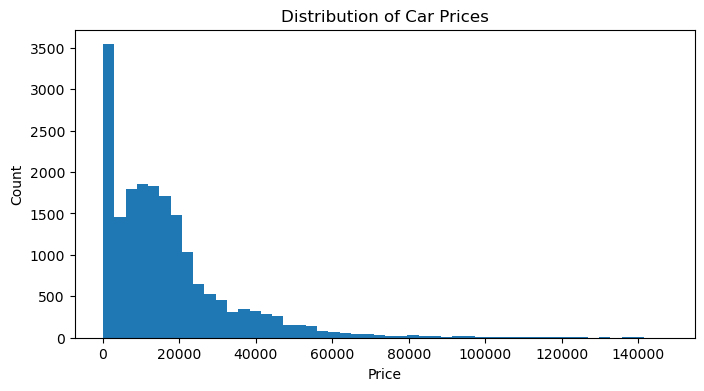

In [18]:
# Plot without those extreme prices
plt.figure(figsize=(8, 4))
plt.hist(df_cleaned['Price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Car Prices')
plt.show()

Due to heavy skewness of the prices, we will try to plot the distribution in it's log-values. It might help us later in the baseline model, to improve linearity between the predicted variable and the predictors.

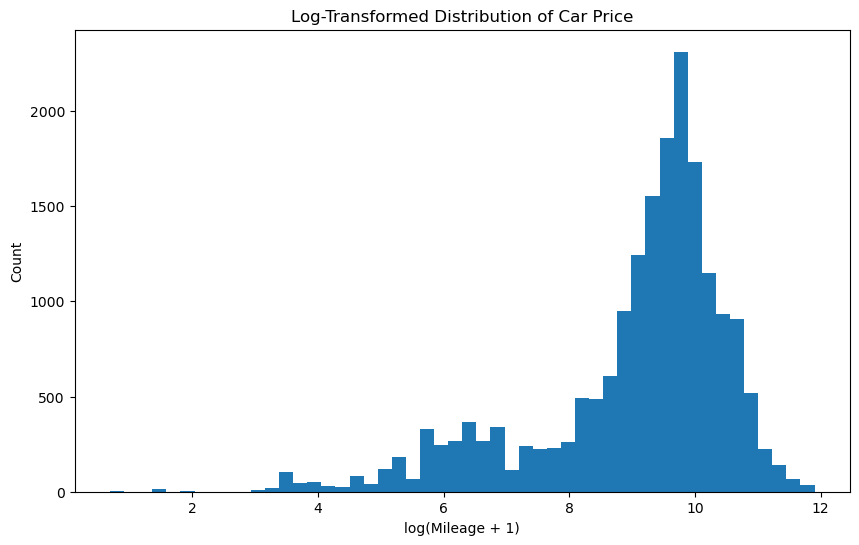

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(df_cleaned['Price']), bins=50)
plt.xlabel('log(Mileage + 1)')
plt.ylabel('Count')
plt.title('Log-Transformed Distribution of Car Price')
plt.show()

In [20]:
#we do the same for mileage:
print(df_cleaned['Mileage'].describe())

print(" ")

Q1 = df_cleaned['Mileage'].quantile(0.25)
Q3 = df_cleaned['Mileage'].quantile(0.75)
IQR = Q3 - Q1
print("upper bound: ", Q3 + 1.5 * IQR)

count    1.889700e+04
mean     1.557538e+06
std      4.883703e+07
min      0.000000e+00
25%      7.039500e+04
50%      1.266550e+05
75%      1.893470e+05
max      2.147484e+09
Name: Mileage, dtype: float64
 
upper bound:  367775.0


since the upper bound for mileage is 367,775, we will check for removing a reasonable number of recordings, to avoid removing to much rows:

In [21]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Mileage'] > 1000000])}")

Number of entries: 73


In [22]:
df_cleaned = df_cleaned[df_cleaned['Mileage'] <= 1000000].copy()

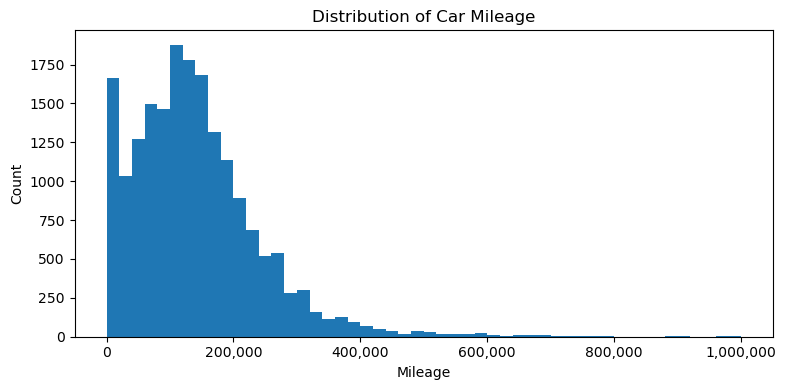

In [23]:
plt.figure(figsize=(8, 4))
plt.hist(df_cleaned['Mileage'], bins=50)
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.title('Distribution of Car Mileage')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

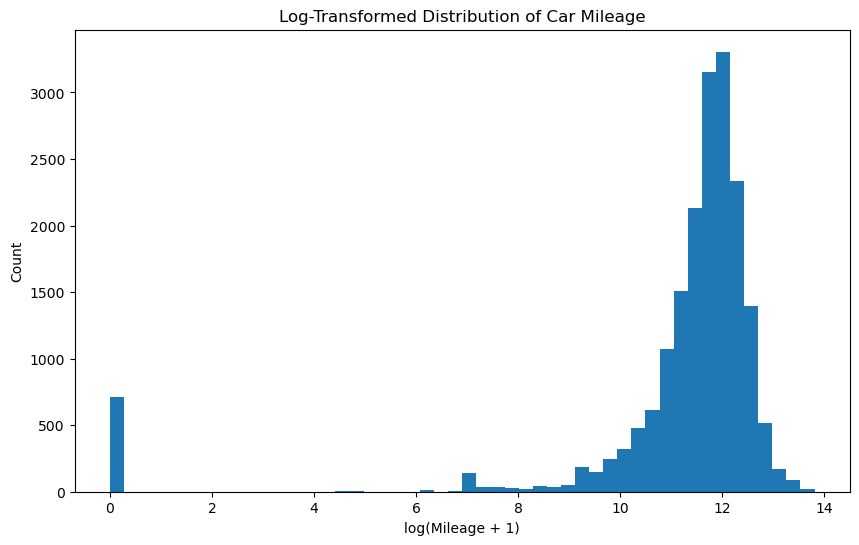

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(df_cleaned['Mileage']), bins=50)
plt.xlabel('log(Mileage + 1)')
plt.ylabel('Count')
plt.title('Log-Transformed Distribution of Car Mileage')
plt.show()

In [44]:
# another check for our features and missing values:
print("Dataset shape: ", df_cleaned.shape)
print("Columns and Types:")
print(df_cleaned.dtypes)
print(" ")
print("Missing Values:")
df_cleaned.isnull().sum()

Dataset shape:  (18824, 14)
Columns and Types:
Price                 int64
Levy                float64
Manufacturer         object
Category             object
Leather interior      int64
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                 int64
Airbags               int64
Turbo                 int32
Age                   int64
dtype: object
 
Missing Values:


Price               0
Levy                0
Manufacturer        0
Category            0
Leather interior    0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Airbags             0
Turbo               0
Age                 0
dtype: int64

We can still see some missing values for the Levy. Levy generally refers to a tax or fee imposed by the government based on characteristics of the vehicle. Levy is influenced by the cars features like engine volume, age, vehicle type etc. We will impute missing data for levy based on engine volume and category - we will find the median value for engine volume and category and fill the missing levy based on this value.

In [35]:
group_medians = df_cleaned.groupby(['Engine volume', 'Category'])['Levy'].median()
group_medians.isnull().sum()

91

In [45]:
#Since there are some in group_median that has NaN, 
# we will create another a more general group_medians, this time by engine volume only:
engine_volume_medians = df_cleaned.groupby('Engine volume')['Levy'].median()
print("Number of engine_volume_medians NaNs: ", engine_volume_medians.isnull().sum())

# There are still NaNs, hence we will create a global median for the rest
global_median_levy = df_cleaned['Levy'].median()

Number of engine_volume_medians NaNs:  0


In [38]:
def impute_levy(row):
    if pd.isnull(row['Levy']):
        key = (row['Engine volume'], row['Category']) # first group_median
        levy_value = group_medians.get(key, np.nan)
        
        if pd.isnull(levy_value):  # If group_median not found, use engine_volume_medians
            levy_value = engine_volume_medians.get(row['Engine volume'], np.nan)
            
        if pd.isnull(levy_value):  # If not found, use global_median_levy
            levy_value = global_median_levy
            
        return levy_value
    return row['Levy']

In [46]:
# applying the imputation
# we will use the "regular" imputation for df_baseline, 
# because maybe later we will use different approach for imputation
df_baseline = df_cleaned.copy()
df_baseline['Levy'] = df_baseline.apply(impute_levy, axis=1)

In [47]:
# Checking again for missing values after the data cleansing
df_baseline.isnull().sum()

Price               0
Levy                0
Manufacturer        0
Category            0
Leather interior    0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Airbags             0
Turbo               0
Age                 0
dtype: int64

Now it looks like we are done with the missing values. Before creating our baseline model, we have to take care the rest of the categorical features: 
* **Manufacturer** - Since we believe that there is a strong correlation between the brand and the price, we will encode this by ranking the average price per manufacturer. This captures the average value impact of each manufacturer on price, which makes intuitive sense (e.g. Mercedes vs. Hyundai). It will also will help us to reduce cardinality to a single numeric column, unlike one-hot encoding. However, we're familiar with this problematic feature transformation since we are encoding the target variable. Instead of assigning each manufacturer a unique rank, we will group them into price-based ranges that will hopefully prevent over-fitting and reduces sensitivity to small price differences between manufacturers.
* **Category** - We will check whether to use dummy variables or ordinal values.
* **Gear-Box Type** - We will check whether to use dummy variables or ordinal values.
* **Drive Wheels** - We will check whether to use dummy variables or ordinal values.


In [60]:
# we will create a list of averages by manufacturer
manufacturer_avg_price = df_baseline.groupby('Manufacturer')['Price'].mean()

In [63]:
print("min: ",manufacturer_avg_price.min())
print("max: ",manufacturer_avg_price.max())
print("len: ",len(manufacturer_avg_price))

min:  178.5
max:  66955.5
len:  63


In [62]:
# we will create the bins, then we assing them to the manufacturer average list:
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7]
manufacturer_price_bins = pd.cut(manufacturer_avg_price, bins=bins, labels=labels)
manufacturer_price_bins

Manufacturer
ACURA           1
ALFA ROMEO      1
ASTON MARTIN    6
AUDI            2
BMW             3
               ..
VAZ             1
VOLKSWAGEN      2
VOLVO           2
ZAZ             1
სხვა            2
Name: Price, Length: 63, dtype: category
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

In [64]:
# lastly we will map each row by the manufacturer_price_bins list
df_baseline['Manufacturer_encoded'] = df_baseline['Manufacturer'].map(manufacturer_price_bins)
df_baseline.head()

,Price,Levy,Manufacturer,Category,Leather interior,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Airbags,Turbo,Age,Manufacturer_encoded
0,13328,1399.0,LEXUS,Jeep,1,3.5,186005,6.0,Automatic,4x4,4,12,0,15,2
1,16621,1018.0,CHEVROLET,Jeep,0,3.0,192000,6.0,Tiptronic,4x4,4,8,0,14,2
2,8467,574.0,HONDA,Hatchback,0,1.3,200000,4.0,Variator,Front,4,2,0,19,2
3,3607,862.0,FORD,Jeep,1,2.5,168966,4.0,Automatic,4x4,4,0,0,14,2
4,11726,446.0,HONDA,Hatchback,1,1.3,91901,4.0,Automatic,Front,4,4,0,11,2


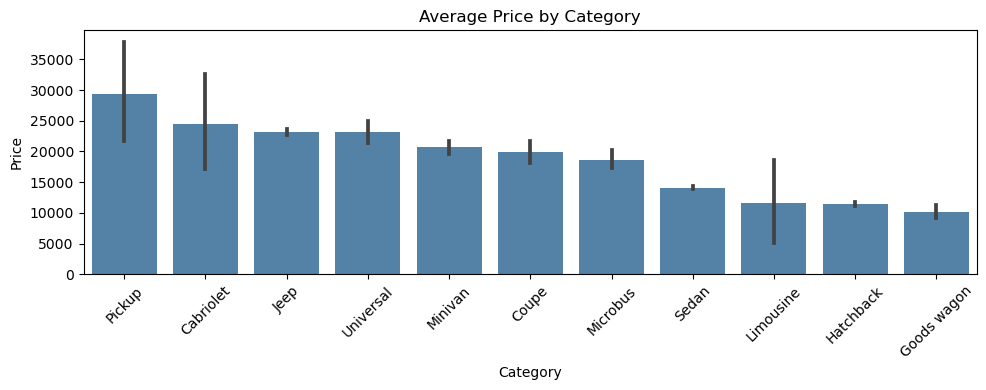

In [95]:
# before proceeding to the last 3 variables, we'll check if there is some correlation between the price
# and those variable. If there is, we would prefer to transform them into a ordinal variable
# rather than one-hot encoding

avg_price_by_category = df_baseline.groupby('Category')['Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(x='Category', y='Price', data=df_baseline, color='steelblue', order = avg_price_by_category.index)
plt.title('Average Price by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

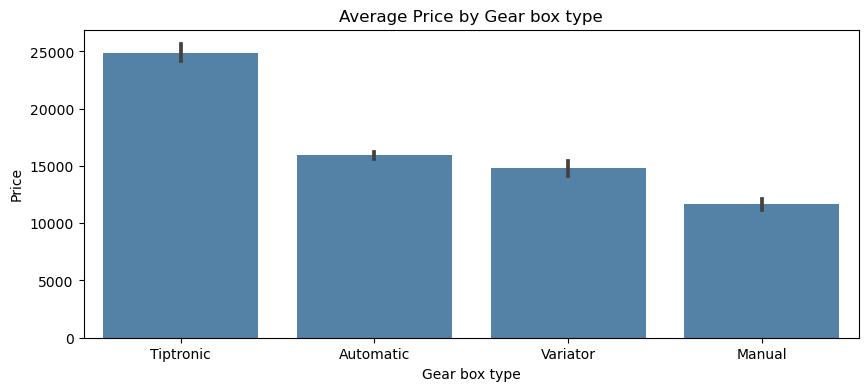

In [96]:
avg_price_by_gear = df_baseline.groupby('Gear box type')['Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x='Gear box type', y='Price', data=df_baseline, color='steelblue', order = avg_price_by_gear.index)
plt.title('Average Price by Gear box type')
plt.show()

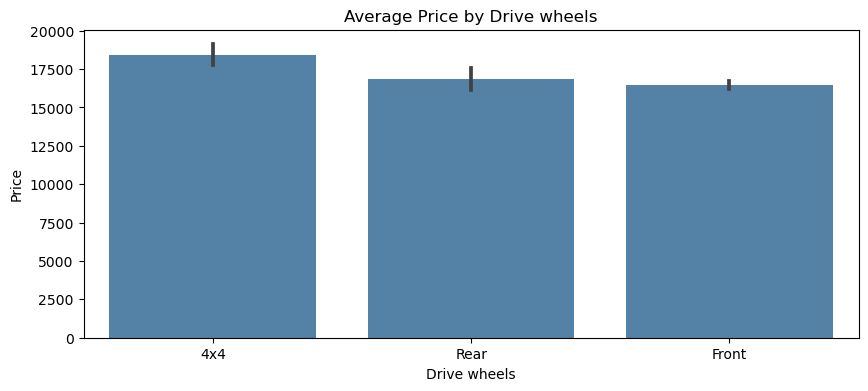

In [99]:
avg_price_by_Drive_wheels = df_baseline.groupby('Drive wheels')['Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x='Drive wheels', y='Price', data=df_baseline, color='steelblue', order = avg_price_by_Drive_wheels.index)
plt.title('Average Price by Drive wheels')
plt.show()

The three bar plots above show the average car price for each category within the variables Category, Gear box type, and Drive wheels. These plots reveal the patterns in how these features relate to the target variable (Price):

* Category: There is a clear ranking among vehicle types. High-priced categories like Pickup, Cabriolet, and jeep, consistently outperform lower-end types like Goods wagon and Hatchback.

* Gear box type: Average prices decrease consistently from Tiptronic to Manual, indicating a strong ordinal relationship. This also corresponds to common knowledge that e.g. automatic car is more expenssive than manual car.

* Drive wheels: Although differences are smaller, there's a consistent trend with 4x4 vehicles priced higher than Rear and Front drive types.

Given these ordered relationships with price, it's appropriate to encode these categorical variables as ordinal values (e.g., using ranks based on average price), rather than one-hot encoding. This approach reduces dimensionality while preserving the underlying value hierarchy these features represent.

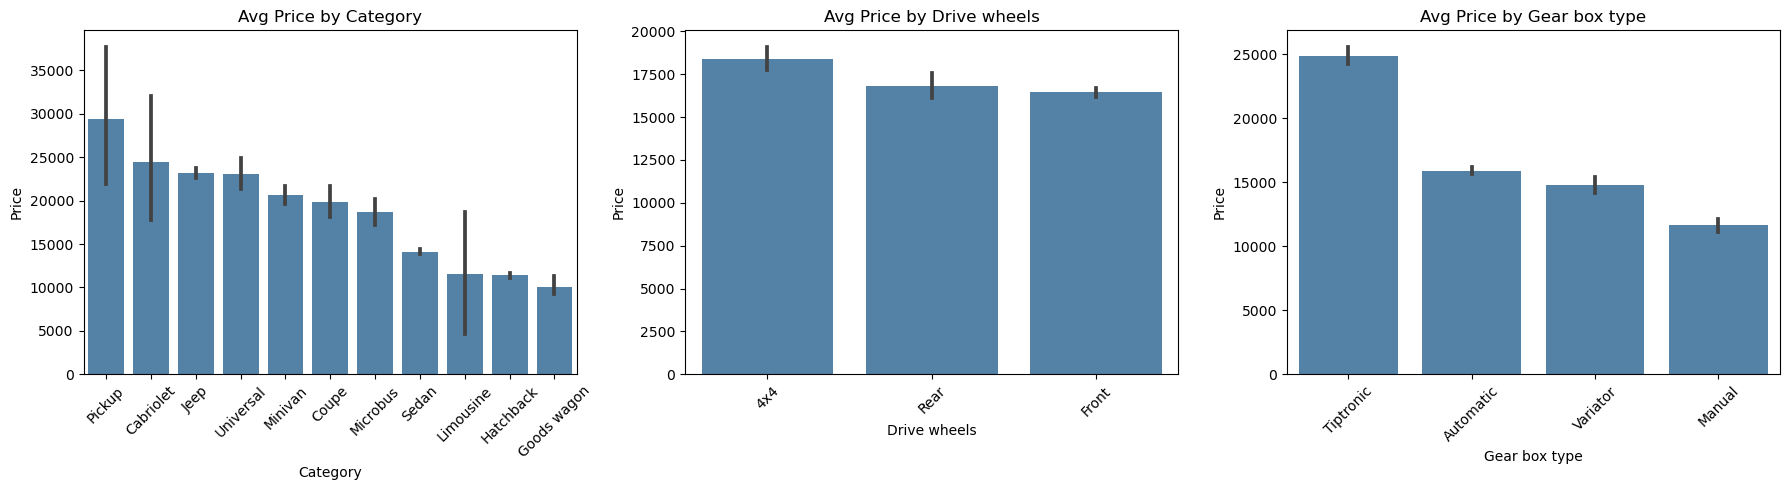

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

sns.barplot(x='Category', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_category.index, ax=axes[0])
axes[0].set_title('Avg Price by Category')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Drive wheels', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_Drive_wheels.index, ax=axes[1])
axes[1].set_title('Avg Price by Drive wheels')
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x='Gear box type', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_gear.index, ax=axes[2])
axes[2].set_title('Avg Price by Gear box type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
fig.savefig('categorical_vars.png', bbox_inches='tight')
plt.show()

In [27]:

# Features and target
X = df_cleaned.drop(columns=['Price'])
y = df_cleaned['Price']

# Compute mutual information
mi_scores = mutual_info_regression(X, y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Feature Importance (Mutual Information with Price)", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


ValueError: could not convert string to float: 'LEXUS'

### Data Preprocessing Summary

Before building a regression model, several steps were taken to clean and prepare the data:

* Dropped unnecessary columns: Features like ID, Color, Model, and Steering Wheel Side were removed because they either had too many unique values, were unlikely to influence price directly, or were redundant.

* Fixed data formatting issues: Some columns had text mixed with numbers (e.g. "km" in mileage or "Turbo" in engine volume). These were cleaned so that only numerical values remained. For instance, we also created a new column to indicate whether a car had a turbo engine.

* Converted categorical variables: Categorical features (like Leather Interior) were converted to numerical form to work with machine learning models.

* Handled missing and invalid values: Placeholder values like "-" were replaced with actual missing values (NaN) and converted to proper numerical types.

* Created a new feature for car age: Instead of using the production year directly, we calculated the car's age by subtracting the production year from the current year.

* Removed outliers: Extremely high values for price and mileage were removed because they could distort the results of the model. The cutoffs were based on distribution analysis using boxplots and interquartile range (IQR).

* Applied log transformation: Car prices and mileage were both highly skewed. Applying a logarithmic transformation helps to reduce skewness and may improve model performance by making the data more normally distributed.

* Handling Levy missing values - we created a few base groups that Levy is influenced by (engine volume, and category, engine volume, and general) and applied imputation using the median of those groups.

* Handling manufacturer, Category, Gear box type, and Drive wheels: we turned those variables into ordinal variables based on their pattern with the price. The pattern also corresponded with believes and knowledge - for instance, a manual car is cheaper than automatic car (for gear box), front wheels drive are usually cheaper than rear wheels drive etc. For the manufacturer feature, we believe that there is a strong correlation between the brand and the price. Hence, we groupped the average price by manufacturer, this captures the average value impact of each manufacturer on price, which makes intuitive sense (e.g. Mercedes vs. Hyundai). While keeping in mind this problematic feature transformation we splitted the brands into bins based on average price ranges to prevent over-fitting.